In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import gc
import psutil
import GPUtil
import mlflow.pytorch
import mlflow

# Enable MLflow autologging for PyTorch
mlflow.pytorch.autolog()
mlflow.set_tracking_uri(uri="file:///C:/Users/jcwin/OneDrive - University of Southampton/_Southampton/2024-25/Star-Classifier/mlflow")
mlflow.set_experiment("Fusion_Gaia_LAMOST")

2024/10/18 17:23:37 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.4.1, but the installed version is 2.4.1+cu124. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.


<Experiment: artifact_location=('file:///C:/Users/jcwin/OneDrive - University of '
 'Southampton/_Southampton/2024-25/Star-Classifier/mlflow/286740436428343516'), creation_time=1729267230861, experiment_id='286740436428343516', last_update_time=1729267230861, lifecycle_stage='active', name='Fusion_Gaia_LAMOST', tags={}>

In [18]:
class ConvNetFusion(nn.Module):
    def __init__(self, input_shape, num_classes, gaia_input_size, 
                 num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                 kernel_size=9,
                 dense_units=[256, 256, 256, 128, 128, 128, 64, 64, 64],
                 dropout_rate=0.2, 
                 gaia_fusion_units=512,
                 padding='same'):
        super(ConvNetFusion, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        in_channels = 1  # Since it's a 1D input
        
        # Add convolutional layers
        for filters in num_filters:
            conv_layer = nn.Conv1d(in_channels=in_channels, out_channels=filters, kernel_size=kernel_size, padding=kernel_size//2)
            self.conv_layers.append(conv_layer)
            self.pool_layers.append(nn.MaxPool1d(kernel_size=2))
            in_channels = filters
        
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        
        # Compute the flattened output size (based on input shape and pooling)
        final_seq_len = input_shape[0] // (2 ** len(num_filters))  # After all pooling layers
        
        # Add Gaia features to the input
        self.gaia_input_layer = nn.Linear(gaia_input_size, gaia_fusion_units)

        # Add dense layers
        dense_input_units = num_filters[-1] * final_seq_len + gaia_fusion_units  # Add Gaia features to the dense input
        self.dense_layers = nn.ModuleList()
        for units in dense_units:
            self.dense_layers.append(nn.Linear(dense_input_units, units))
            dense_input_units = units
        
        # Output layer
        self.output_layer = nn.Linear(dense_input_units, num_classes)
    
    def forward(self, x_conv, x_gaia):
        # Pass through convolutional layers
        for conv_layer, pool_layer in zip(self.conv_layers, self.pool_layers):
            x_conv = pool_layer(torch.relu(conv_layer(x_conv)))
            x_conv = self.dropout(x_conv)
        # Flatten the conv output
        x_conv = self.flatten(x_conv)

        # Connect Gaia features to a separate dense layer and connect after to the main network
        x_gaia = torch.relu(self.gaia_input_layer(x_gaia))

        
        # Concatenate Gaia features
        x = torch.cat((x_conv, x_gaia), dim=1)
        
        # Pass through dense layers
        for dense_layer in self.dense_layers:
            x = torch.relu(dense_layer(x))
            x = self.dropout(x)
        
        # Output layer
        x = self.output_layer(x)
        return torch.softmax(x, dim=1)
# Create Datasets
class BalancedDatasetFusion(Dataset):
    def __init__(self, X_conv, X_gaia, y, limit_per_label=1600):
        self.X_conv = X_conv
        self.X_gaia = X_gaia
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X_conv[index], self.X_gaia[index], self.y[index]

# Define a function to train the model
def train_model(model, train_loader, val_loader, num_epochs=200, lr=1e-4, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        # Training loop
        for X_conv, X_gaia, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X_conv, X_gaia)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_conv.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y).sum().item()
            total_train += y.size(0)

        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation loop
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for X_conv, X_gaia, y in val_loader:
                outputs = model(X_conv, X_gaia)
                loss = criterion(outputs, y)

                val_loss += loss.item() * X_conv.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == y).sum().item()
                total_val += y.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct_val / total_val

        # Log metrics for MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Load the best model weights before returning
    model.load_state_dict(best_model)
    return model

# Function to print confusion matrix and log it with MLflow
def print_confusion_matrix(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_conv, X_gaia, y in val_loader:
            outputs = model(X_conv, X_gaia)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Log confusion matrix
    mlflow.log_artifact(confusion_matrix_to_image(cm), artifact_path="confusion_matrix")

def confusion_matrix_to_image(cm):
    # Convert confusion matrix to an image (optional)
    import matplotlib.pyplot as plt
    import seaborn as sns
    import io

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

    # Save the figure to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    # Return the buffer
    return buf


In [19]:
# Load and preprocess data
X = pd.read_pickle("Pickles/fusionv0/train.pkl")
gaia_features = ["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
           "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
           "phot_bp_mean_flux_error", "phot_rp_mean_flux_error"]

# Extract Gaia data
X_gaia = X[gaia_features].values
X_conv = X.drop(gaia_features + ["label"], axis=1).values
y = X["label"]

# Mapping labels to integers
label_mapping = {'star': 0, 'binary_star': 1, 'galaxy': 2, 'agn': 3}
y = y.map(label_mapping).values

# Split data into train and validation
X_train_conv, X_val_conv, X_train_gaia, X_val_gaia, y_train, y_val = train_test_split(X_conv, X_gaia, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_conv = torch.tensor(X_train_conv, dtype=torch.float32).unsqueeze(1)
X_val_conv = torch.tensor(X_val_conv, dtype=torch.float32).unsqueeze(1)
X_train_gaia = torch.tensor(X_train_gaia, dtype=torch.float32)
X_val_gaia = torch.tensor(X_val_gaia, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders
train_dataset = BalancedDatasetFusion(X_train_conv, X_train_gaia, y_train)
val_dataset = BalancedDatasetFusion(X_val_conv, X_val_gaia, y_val)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [20]:
# Initialize model with Gaia input size
gaia_input_size = X_train_gaia.shape[1]
print(f"Gaia input size: {gaia_input_size}")
filters=[128, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512]
dense=[1024, 1024, 512, 256, 64]

model = ConvNetFusion(input_shape=(3748,), num_classes=4, gaia_input_size=gaia_input_size, 
                      num_filters=filters, kernel_size=9, dense_units=dense, dropout_rate=0.2, gaia_fusion_units=512)
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Gaia input size: 17
ConvNetFusion(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (1-2): 2 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (3): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (4-5): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (6): Conv1d(256, 512, kernel_size=(9,), stride=(1,), padding=(4,))
    (7-10): 4 x Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=(4,))
  )
  (pool_layers): ModuleList(
    (0-10): 11 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (gaia_input_layer): Linear(in_features=17, out_features=512, bias=True)
  (dense_layers): ModuleList(
    (0-1): 2 x Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_f

In [26]:
# Initialize the model
gaia_input_size = X_train_gaia.shape[1]
filters = [128, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512]
dense = [1024, 1024, 512, 256, 64]

# smaller model
filters = [32, 64,64,64, 128, 128, 128, 256, 256, 256]
dense = [512, 512, 256, 256, 128]


model = ConvNetFusion(input_shape=(3748,), num_classes=4, gaia_input_size=gaia_input_size, 
                      num_filters=filters, kernel_size=9, dense_units=dense, dropout_rate=0.2, gaia_fusion_units=256)
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

ConvNetFusion(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): Conv1d(32, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (2-3): 2 x Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (5-6): 2 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (8-9): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  )
  (pool_layers): ModuleList(
    (0-9): 10 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (gaia_input_layer): Linear(in_features=17, out_features=256, bias=True)
  (dense_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
   

2024/10/18 17:35:52 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch [1/200], Train Loss: 1.3845, Train Acc: 0.2655, Val Loss: 1.3791, Val Acc: 0.3178
Epoch [2/200], Train Loss: 1.3766, Train Acc: 0.3881, Val Loss: 1.3599, Val Acc: 0.6179
Epoch [3/200], Train Loss: 1.3386, Train Acc: 0.4141, Val Loss: 1.2968, Val Acc: 0.5848
Epoch [4/200], Train Loss: 1.2362, Train Acc: 0.5119, Val Loss: 1.1819, Val Acc: 0.6002
Epoch [5/200], Train Loss: 1.1394, Train Acc: 0.6165, Val Loss: 1.1294, Val Acc: 0.6481
Epoch [6/200], Train Loss: 1.0797, Train Acc: 0.6674, Val Loss: 1.1051, Val Acc: 0.6648
Epoch [7/200], Train Loss: 1.0563, Train Acc: 0.6876, Val Loss: 1.0900, Val Acc: 0.6682
Epoch [8/200], Train Loss: 1.0423, Train Acc: 0.6974, Val Loss: 1.1101, Val Acc: 0.6631
Epoch [9/200], Train Loss: 1.0268, Train Acc: 0.7125, Val Loss: 1.0964, Val Acc: 0.6730
Epoch [10/200], Train Loss: 1.0200, Train Acc: 0.7239, Val Loss: 1.0903, Val Acc: 0.6746
Epoch [11/200], Train Loss: 1.0120, Train Acc: 0.7298, Val Loss: 1.0754, Val Acc: 0.6769
Epoch [12/200], Train Loss: 1.

2024/10/18 18:44:11 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/10/18 18:44:11 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


TypeError: stat: path should be string, bytes, os.PathLike or integer, not BytesIO

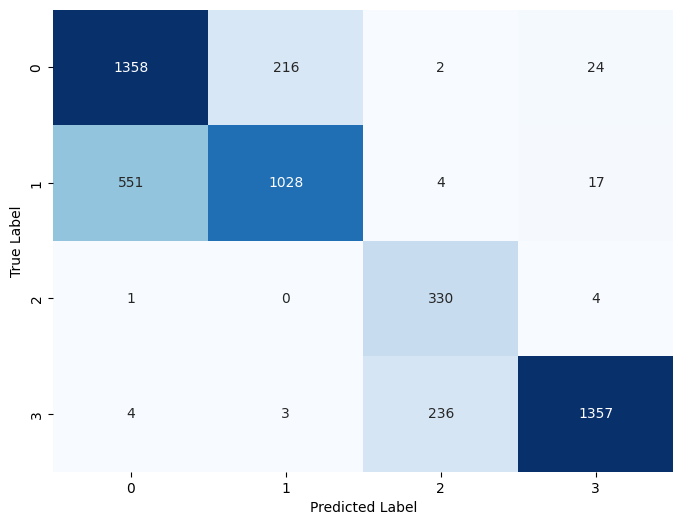

In [27]:
# Training parameters
num_epochs = 200
lr = 1e-4
patience = 10
batch_size = 512

# Start an MLflow run
with mlflow.start_run(log_system_metrics=True):
    # Log parameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("lr", lr)
    mlflow.log_param("patience", patience)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_filters", filters)
    mlflow.log_param("dense_units", dense)
    mlflow.log_param("dropout_rate", 0.2)
    mlflow.log_param("kernel_size", 9)

    # Train the model
    trained_model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, lr=lr, patience=patience)

    # Evaluate the model
    print_confusion_matrix(trained_model, val_loader)
    # Save the model in MLflow
    mlflow.pytorch.log_model(trained_model, "model")